In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import fileinput
import glob
import os
import shutil
import random
pd.set_option('display.max_columns', None)

In [3]:
#################################
#### FUNCTIONS USED LATER #######
#################################
columns = ['sur', 'sur2', 't', 'e1','e2','g1','g2','a1','i1','i2','i','spin1h','spintot',
           'beta','vp','spin1e','spin1q','spin2e','spin2q','spin2h','htot','m1','R1','m2',
           'R2','a2','m3','Roche1','R1','type1','type2','type3','beta2','gamma','gamma2','flag']
def get_first_line(file_path): #get first line 
    with open(file_path) as f:
        return f.readline()

def get_last_line(file_path): #faster way to get last line
    with open(file_path, 'rb') as file:
        try:
            file.seek(-2, os.SEEK_END)
            while file.read(1) != b'\n':
                file.seek(-2, os.SEEK_CUR)
        except OSError:
            file.seek(0)
        last_line = file.readline().decode()
        return last_line
def maybe_float(s):
    try:
        return float(s)
    except (ValueError, TypeError):
        return s

def Kepler_3rdLaw(P,m1,m2):
    '''
    Function to get semi-major axis from period using K3L
    :param P: Period of orbit in **yr**
    :return: returns SMA (a) in **AU**
    '''
    G = 1.19e-19 #G in AU^3/M_sun*s^2
    a = np.power( ( (P**2)*(m1+m2) ) ,1./3.) #Kepler's Third Law
    return(a)
def Roche_limit(q):
    '''
    Function to get Roche Limit of specified mass ratios (q)
    :param q: mass ratio
    :return: returns the Roche Limit (RHS of Eqn.1 from Naoz+2014)
    '''
    num1,num2=0.49,0.6;
    return num1*np.power(q,2./3.)/(0.6* np.power(q,2./3.)+np.log(1+np.sqrt(q)));
def pos_normal(mean, sigma): 
    '''
    Function to get only positive values from normal distribution recursively
    '''
    x = np.random.normal(mean,sigma)
    return(x if x>=0 else pos_normal(mean,sigma))
def rndm(a, b, g, size=1):
    """Power-law gen for pdf(x)\propto x^{g-1} for a<=x<=b"""
    r = np.random.random(size=size)
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g) 
 
def miller_scalo_IMF(arr,lower=1.0,upper=8.0):

    if 0.1<arr<=1: return rndm(0.1,1.0,-0.25)[0]
    if 1.<arr<=2.: return rndm(1.0,2.0,-1.00)[0]
    if 2.<arr<=10: return rndm(2.0,8.0,-1.30)[0]
    if 10<arr<=25: return rndm(10.0,125.0,-2.30)[0]

#Setup for the MS IMF
MS_IMF_gen = np.vectorize(lambda arr: miller_scalo_IMF(arr)) #vectorize the function
x = np.linspace(1,8,int(1e6))
MS_IMF_samples = MS_IMF_gen(x)
n_MS, bins_MS, patches = plt.hist(MS_IMF_samples,bins=500,cumulative=True,density=True,histtype='step') 
plt.clf()

def initial_conditions(IMF : str = '1'): 
    IMF_chosen = IMF
    if IMF == '1': 
        m1=1. #default m1= 1 M_sun
    elif IMF == 'Salpeter': 
        m1 = rndm(1.0,8.0,-1.35)[0] #Salpeter PDF #or 1
    elif IMF == 'MS': 
        m1 = random.choices(bins_MS[:-1], cum_weights = n_MS)[0]
    
    
    q_in,q_out = pos_normal(0.23,0.42),pos_normal(0.23,0.42)
    
    m2 = m1*q_in
    m3 = q_out*(m1+m2)
    
    R1 = m1
    R2 = R1*np.power(m2/m1,4./5.)
    
    spin1P = 25.
    spin2P = 25.
    
    beta = np.random.uniform(0,180)
    beta2 = 0.
    
    gamma = 45.
    gamma2 = 45.
    
    g1 = np.random.uniform(0,360)
    g2 = np.random.uniform(0,360)
    
    age = 12.5*1e3 #*1.e6, means 10*1e9

    P_in,P_out = 10**np.random.normal(4.8,2.3), 10**np.random.normal(4.8,2.3) #periods in days
    P_in,P_out = P_in/365.25, P_out/365.25 #periods in yr
    
    a1,a2 = Kepler_3rdLaw(P_in,m1,m2), Kepler_3rdLaw(P_out,m1+m2,m3) #SMA in AU
    e1,e2 = np.random.uniform(0,1),np.random.uniform(0,1)

    #inclination
    cosi = np.random.uniform(np.cos(0),np.cos(np.pi))
    i = np.rad2deg(np.arccos(cosi))

    #stability_criteria from Mardling & Aarseth (2001),**BOOL**
    stable = 2.8 * np.power(1.+ q_out,2./5.) * np.power(1.+e2, 2./5.)*np.power(1.-e2, -6./5.)*(1-(0.3*i/180.)) 
    epsilon = (a1/a2) * e2 / (1-e2**2) #epsilon criterion from Naoz+2014
    
    Roche1=Roche_limit(m1/m2);
    Roche2=Roche_limit(m2/m1);
    Rsun = (695500*6.68459e-9)  #sun radius in AU

    # BOOLEANS to check that parameters are **STABLE**
    stability_criteria = (a2/a1) > stable
    epsilon_criteria = epsilon < 0.1
    Roche1_criteria = R1*Rsun < (a1*(1-e1)*Roche1)
    Roche2_criteria = R2*Rsun < (a1*(1-e1)*Roche2)
    mass_criteria =  m1>0 and m2>0 and m3>0 #this condition should already be met bc pos_normal function
    criteria = (stability_criteria and mass_criteria and epsilon_criteria and (Roche1_criteria and Roche2_criteria) )

    # recurse if criteria are not met until criteria are met
    if criteria:
        return(np.array([m1,m2,m3,R1,R2,spin1P,spin2P,beta,beta2,gamma,gamma2,a1,a2,e1,e2,g1,g2,i,age]))
    else:
        return initial_conditions(IMF = IMF_chosen)
    

<Figure size 640x480 with 0 Axes>

In [5]:
m1s=[]
m1s_kosh=[]
m1s_salp=[]
m1s_salp_kosh=[]
for _ in range(1000):
    m1s.append(initial_conditions(IMF = 'MS')[0])
    m1s_kosh.append( random.choices(bins_MS[:-1], cum_weights = n_MS)[0])
    m1s_salp.append(initial_conditions(IMF='Salpeter')[0])
    m1s_salp_kosh.append(rndm(1.0,8.0,-1.35)[0])
plt.hist(m1s, bins=30,histtype='step',density=True)
plt.hist(m1s_kosh, bins=30,histtype='step',density=True)
#plt.hist(m1s_salp, bins=30,histtype='step',density=True)
#plt.hist(m1s_salp_kosh, bins=30,histtype='step',density=True)
plt.show()

KeyboardInterrupt: 

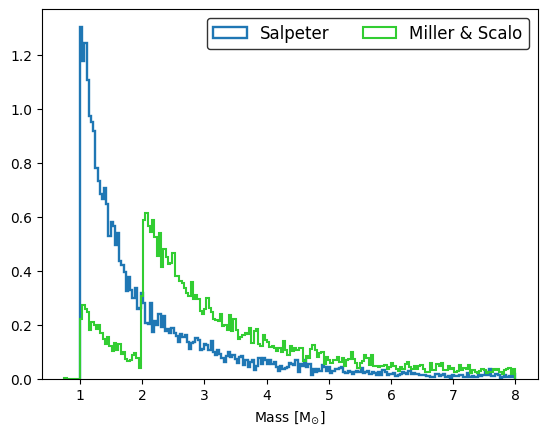

In [274]:
#SALPETER IMF
c=[]
MS=[]
x = np.linspace(1,8,10000)
MS_IMF_samples = MS_IMF_gen(x)
y= 1.4*x**-2.35
for i in range(10000):
    c.append(rndm(1.0,8.0,-1.35)[0])
    
plt.hist(c,histtype='step',bins=200,linewidth=1.7,density=True,label = 'Salpeter')
plt.hist(MS_IMF_samples,histtype='step',density=True,bins=200,linewidth=1.5,color='limegreen',label='Miller & Scalo')

#plt.plot(x,y,c='r')
plt.xlabel('Mass [M$_{\odot}$]')
plt.legend(edgecolor='k',fontsize=12,ncol=2)


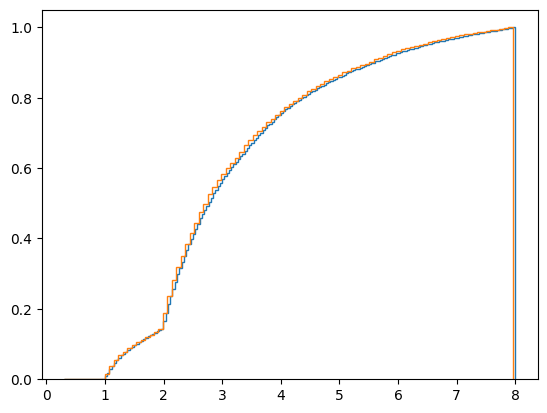

In [254]:
n, bins, patches = plt.hist(MS_IMF_samples,bins=200,cumulative=True,density=True,histtype='step')

import random
x = [random.choices(bins[:-1], cum_weights = n)[0] for x in range(10000)]

plt.hist(x,cumulative=True,histtype='step',density=True,bins=100)

plt.show()


In [8]:
#############################################
##### FUNCTIONs THAT CREATES triple.in's #####
#############################################

#OSPE FLAGS; 0 (yes) 1 (no)
quadrupole = 0
octupole = 0
GR = 0
TF = 0
ML1 = 0
MB1 = 0
ML2 = 0
MB2 = 0
ML3 = 0
SSE1 = 0
SSE2 = 0
SSE3 = 0
tMSMyr = 0

# ==========================================================================

def create_file(initial_conditions, file_dir, file_end, eps = 1e-16, restart=False):
    """
    Function to create a triple.in file with input initial conditions
    :param initial_conditions: array of initial conditions from generate_inicon
    :param file_dir: directory to store triple.in files in
    :param file_end: file suffix (i.e. '1' to write triple.in1)
    :param start_time: system age to start simulations on
    :param restart: flag set to True if code is being re-started on Hoffman
    :return: writes a triple.inX file and saves to file_dir
    """
    # open new file
    filename = file_dir + '/' + 'triple.in' + file_end
    out = open(filename,'w')
    
    # write header
    out.write("#########################################################################\n")
    out.write("## Read in the initial orbital parameters of the triple system         ##\n")
    out.write("## Mass in M_sol, semimajor axis in AU                                 ##\n")
    out.write("#########################################################################\n")
    out.write("\n")
    
    if restart==False:
        out.write("__m1_______m2___________m3________R1(Rsun)____R2(Rsun)____Spin1P(day)__Spin2P(day)_ _beta(s_O_deg)__beta2(s_O_deg)__gamma(s_O_deg)__gamma2(s_O_deg)__a1______a2____e1____e2____g1(deg)__g2(deg)__i(deg)__age(Myr)___ :::\n")
    
    elif restart==True:
        out.write("__m1_______m2___________m3________R1(Rsun)____R2(Rsun)____Spin1P(day)__Spin2P(day)_    _beta(s_O_deg)__beta2(s_O_deg)__gamma(s_O_deg)__gamma2(s_O_deg)__a1______a2____e1____e2____g1(deg)__g2(deg)__i(deg)__t_i(yr)__age(Myr)___ :::\n")
        
    out.write("\n")
    
    # add initial conditions
    out.write('  '.join([str(i) for i in initial_conditions])+'\n')
    
    # add header for flags
    out.write("\n")
    out.write("#########################################################################\n")
    out.write("## Flags                                                               ##\n")
    
    # quadrupole
    out.write("#########################################################################\n")
    out.write("\n")
    out.write("__QUADRUPOLE(0_yes_1_no)___ :::\n")
    out.write(str(quadrupole)+'\n') # for quadrupole?
    out.write("\n")
    
    # octupole
    out.write("#########################################################################\n")
    out.write("__OCTUPOLE(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(octupole)+'\n') # for octupole?
    out.write("\n")
    
    # GR
    out.write("#########################################################################\n")
    out.write("__GR(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(GR)+'\n') # for GR?
    out.write("\n")
    
    # tidal forces
    out.write("#########################################################################\n")
    out.write("__TF(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(TF)+'\n') #for TF?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__ML1(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(ML1)+'\n') # for ML1?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__MB1(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(MB1)+'\n') # for MB1?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__ML2(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(ML2)+'\n') # for ML2?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__MB2(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(MB2)+'\n') # for MB2?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__ML3(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(ML3)+'\n') # for ML3?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__SSE1(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(SSE1)+'\n') # for SSE1?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__SSE2(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(SSE2)+'\n') # for SSE2?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__SSE3(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(SSE3)+'\n') # for SSE3?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__tMSMyr(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(tMSMyr)+'\n') # for tMSMyr?
    out.write("\n")
    
    # add control parameters section
    out.write("#########################################################################\n")
    out.write("## Control Parameters                                                  ##\n")
    out.write("#########################################################################\n")
    out.write("\n")
    out.write("__eps___ :::\n")
    out.write(str(eps)+"\n")
 #   out.write("1e-16\n")
    
    out.close()

    
############################################################
##### FUNCTION THAT CREATES N triple.in's TO DIRECTORY #####
############################################################
def generate_set_of_files(n, file_dir, start = 1, IMF = '1'):
    """
    Creates a set of triple.in files by iteratively running create_file()
    :param n: number of triple.in files to generate (will create triple.in1-n)
    :param file_dir: directory to store triple.in files in
    :return: writes a n triple.inX file and saves to file_dir
    """
    # for j in range(start,start+n+1):
    #     inicons = initial_conditions()
    #     file_end = str(j)
    #     print(initial_conditions)
    #     create_file(inicons, file_dir,file_end)
    this_IMF = IMF
    n_files = start
    n_max = start + n
    while n_files < n_max:
        inicons = initial_conditions(IMF = this_IMF)
        
        
        file_end = str(n_files)
        create_file(inicons, file_dir, file_end)
        n_files += 1

In [320]:
# ==========================================================================
# RUNNING THE ABOVE FUNCTIONS TO GENERATE FILES 
a = input('Are you sure that you want to continue? [y/n]: ')
if a == 'y' or a == 'Y':
    n=1000
    file_dir='/Users/bijan1339/Desktop/Research/ICs/'
    generate_set_of_files(n,file_dir,start=9000, IMF = 'MS')

In [21]:
columns = ['sur', 'sur2', 't', 'e1','e2','g1','g2','a1','i1','i2','i','spin1h','spintot',
           'beta','vp','spin1e','spin1q','spin2e','spin2q','spin2h','htot','m1','R1','m2',
           'R2','a2','m3','Roche1','R1','type1','type2','type3','beta2','gamma','gamma2','flag']


AU = 1.496E13       # astronomical unit, cm 
Rsun = 6.96e10    # radius of sun, cm 
pi = np.pi          # pi, 

#cassini_n = (7001, 7002, 7003, 7004, 7011, 7013, 7015, 7019, 7021, 7023, 7024, 7025, 7036, 7039, 7058, 7059, 7061, 7063, 7064, 7066, 7067, 7068, 7070, 7072, 7075, 7077, 7078, 7084, 7090, 7092, 7093, 7100, 7102, 7103, 7113, 7116, 7117, 7119, 7120, 7122, 7124, 7126, 7129, 7130, 7138, 7143, 7147, 7151, 7156, 7160, 7161, 7162, 7168, 7172, 7177, 7179, 7180, 7186, 7193, 7196, 7200, 7205, 7206, 7207, 7208, 7209, 7210, 7212, 7215, 7219, 7221, 7222, 7231, 7233, 7234, 7236, 7242, 7243, 7256, 7259, 7263, 7266, 7268, 7274, 7276, 7279, 7282, 7284, 7290, 7292, 7293, 7294, 7296, 7300, 7301, 7302, 7304, 7305, 7307, 7308, 7309, 7310, 7311, 7313, 7315, 7316, 7318, 7322, 7325, 7328, 7331, 7336, 7338, 7342, 7344, 7345, 7347, 7352, 7353, 7359, 7365, 7367, 7368, 7370, 7372, 7374, 7376, 7383, 7385, 7387, 7390, 7394, 7397, 7398, 7401, 7406, 7408, 7413, 7413, 7415, 7419, 7422, 7423, 7425, 7427, 7432, 7433, 7437, 7438, 7444, 7445, 7447, 7450, 7454, 7461, 7465, 7466, 7470, 7476, 7477, 7479, 7482, 7486, 7489, 7491, 7493, 7497, 7505, 7508, 7509, 7513, 7514, 7515, 7517, 7519, 7524, 7525, 7527, 7530, 7533, 7535, 7540, 7546, 7548, 7552, 7557, 7560, 7561, 7563, 7564, 7567, 7568, 7569, 7570, 7571, 7575, 7577, 7579, 7580, 7581, 7582, 7588, 7599, 7601, 7607, 7612, 7620, 7625, 7630, 7631, 7632, 7637, 7642, 7643, 7648, 7651, 7653, 7655, 7657, 7658, 7661, 7662, 7667, 7669, 7670, 7672, 7673, 7683, 7684, 7689, 7690, 7695, 7698, 7702, 7703, 7704, 7710, 7714, 7716, 7718, 7723, 7724, 7729, 7730, 7732, 7736, 7737, 7740, 7743, 7746, 7750, 7751, 7756, 7758, 7759, 7763, 7765, 7767, 7772, 7774, 7780, 7788, 7789, 7790, 7791, 7791, 7794, 7794, 7796, 7801, 7805, 7807, 7808, 7810, 7812, 7813, 7815, 7818, 7822, 7823, 7827, 7834, 7843, 7848, 7849, 7851, 7852, 7853, 7856, 7859, 7862, 7868, 7870, 7874, 7875, 7878, 7881, 7883, 7885, 7886, 7889, 7894, 7898, 7901, 7903, 7904, 7905, 7907, 7909, 7912, 7914, 7916, 7918, 7923, 7926, 7927, 7929, 7933, 7945, 7949, 7955, 7956, 7957, 7958, 7960, 7961, 7964, 7966, 7967, 7977, 7978, 7979, 7981, 7982, 7988, 7995, 7998, 7999)


outputs_directory = '/Users/bijan1339/Desktop/Research/Final_Output8/' #'/Users/bijan1339/Desktop/Research/Outputs/'
inicon_dir = '/Users/bijan1339/Desktop/Research/ICs/' #directory of where triple.in's are
zero_dir = '/Users/bijan1339/Desktop/Research/ICs_Zero/' #for files that didn't start (t=0 or filesize=0), just need to rerun these, no restart
restart_inicon_dir = '/Users/bijan1339/Desktop/Research/ICs_restart' #where to put new restart triple.in's 

#FIND RESTART FILES THAT ARE STILL GOING
filename = '/Users/bijan1339/Desktop/Research/StillGoing.txt'
with open(filename) as file:
    lines = file.readlines()
still_going_n = [int(x.split(' ')[5].split('OSPE_')[-1][:-1]) for x in lines]


never_started=[]
never_started_restart=[]
restart_numbers=[]
all_n=[]
memory_errors=[]
cass_n=[]
x=0
for filename in os.listdir(outputs_directory):
    x+=1
    needs_restart=False
    is_me = False
    
    n = filename.split('_')[-1].split('.')[0]
    if type(maybe_float(n)) is not float:
        continue
    if (
        (filename.endswith('.txt') and filename.startswith('output_') ) and 
        (8000 <= int(n) <=9000)
        ):
        all_n.append(n)
        n = int(n) #output_n.txt
        
        this_file = os.path.join(outputs_directory, filename) #stores FULL filename

        first_line, last_line = get_first_line(this_file).split('\t'), get_last_line(this_file).split('\t') #last line
        first_line, last_line = [x.strip() for x in first_line], [x.strip() for x in last_line]

        if os.stat(this_file).st_size == 0.:
            memory_errors.append(n)
            is_me = True
        elif (
            float(last_line[2]) == 0. and (float(last_line[0]) != 0. and float(last_line[0]) != 4.)
              ) : #last condiition is to check if it was a merger
                #shutil.copy(source,destination)
                shutil.copy(inicon_dir+'triple.in'+str(n), 
                            zero_dir+'triple.in'+str(n) )
                never_started.append(n)
                if n not in still_going_n: needs_restart = True

        if last_line[-1] != 'END' and not is_me:# and float(last_line[2]) <=1e10:# and ( (float(last_line[0]) != 0.) or (float(last_line[0]) != 4.)):
            restart_numbers.append(n)
            # read in parameters from output file
            ip, fp = [maybe_float(y) for y in first_line], [maybe_float(y) for y in last_line]    

            end_time = fp[2] # last time printout of simulation
            
            total_age = 12.5e9
            age = total_age/1e6 #(total_age-end_time)/1e6 # rest of time simulation needs to run to
            e1,e2,a1,i,beta = fp[3], fp[4], fp[7], fp[10],fp[13]
            g1, g2 = np.rad2deg(fp[5]), np.rad2deg(fp[6])
            m1,m2,a2,m3 = ip[21],ip[23],fp[25],ip[26] #taking the INITIAL, initial masses
            R1, R2 = fp[22]*AU/Rsun, fp[24]*AU/Rsun # convert from AU to Rsun
            beta2,gamma,gamma2 = fp[32], fp[33],fp[34]

            # compute spins from output
            spin1h, spin1e, spin1q = fp[11], fp[15], fp[16]
            spin2h, spin2e, spin2q = fp[19], fp[17], fp[18]
            spin1P_radyr = np.sqrt(spin1h**2.+spin1e**2.+spin1q**2.)
            spin2P_radyr = np.sqrt(spin2h**2.+spin2e**2.+spin2q**2.)
            spin1P = 2.*pi*365.25/spin1P_radyr
            spin2P = 2.*pi*365.25/spin2P_radyr

            final_conditions = np.array([m1,m2,m3,R1,R2,spin1P,spin2P,beta,beta2,gamma,gamma2,a1,a2,e1,e2,g1,g2,i,end_time,age])
            create_file(final_conditions, restart_inicon_dir, str(n), restart=True) #create the restart triple.in file

        # else: 
        #     if int(last_line[0]) == 7: cass_n.append(int(n))
    

In [24]:
len(sorted(restart_numbers))

293

In [6]:
restart_numbers=[]
memory_errors=[]
never_started=[]
other_n=[]
x=0
outputs_directory = '/Users/bijan1339/Desktop/Research/Final_Output/'
for filename in os.listdir(outputs_directory):
    x+=1
    n = filename.split('_')[-1].split('.')[0]
    this_file = os.path.join(outputs_directory, filename)
    if type(maybe_float(n)) is not float:
        pass
    if os.stat(this_file).st_size == 0.:
            memory_errors.append(n)
    elif (
        (filename.endswith('.txt') and filename.startswith('output_') ) and 
        (7000 <= int(n) <=8000)
        ):
    
        n = int(n) 

        first_line, last_line = get_first_line(this_file).split('\t'), get_last_line(this_file).split('\t') #last line
        first_line, last_line = [x.strip() for x in first_line], [x.strip() for x in last_line]
        if (
            last_line[-1] != 'END' and n not in still_going_n and 
            ( (float(last_line[0]) != 0.) or (float(last_line[0]) != 4.) ) and 
            float(last_line[2]) <=1e10
           ):
            restart_numbers.append(n)
            create_file(final_conditions, restart_inicon_dir, str(n), restart=True)
            if (
            float(last_line[2]) == 0. and (float(last_line[0]) != 0. and float(last_line[0]) != 4.)
              ) : 
                never_started.append(n)
        
        else: other_n.append(n)


NameError: name 'still_going_n' is not defined

In [267]:
# Go through Final_Ouput2 folder, find file with same name in Final_Ouput folder,
# If the size of the 2 file is bigger, then move it to Final_Ouput folder.
# Else, dont

outputs1_directory = '/Users/bijan1339/Desktop/Research/Final_Output/'
outputs2_directory = '/Users/bijan1339/Desktop/Research/Final_Output2/'

cassini_n = (7001, 7002, 7003, 7004, 7011, 7013, 7015, 7019, 7021, 7023, 7024, 7025, 7036, 7039, 7058, 7059, 7061, 7063, 7064, 7066, 7067, 7068, 7070, 7072, 7075, 7077, 7078, 7084, 7090, 7092, 7093, 7100, 7102, 7103, 7113, 7116, 7117, 7119, 7120, 7122, 7124, 7126, 7129, 7130, 7138, 7143, 7147, 7151, 7156, 7160, 7161, 7162, 7168, 7172, 7177, 7179, 7180, 7186, 7193, 7196, 7200, 7205, 7206, 7207, 7208, 7209, 7210, 7212, 7215, 7219, 7221, 7222, 7231, 7233, 7234, 7236, 7242, 7243, 7256, 7259, 7263, 7266, 7268, 7274, 7276, 7279, 7282, 7284, 7290, 7292, 7293, 7294, 7296, 7300, 7301, 7302, 7304, 7305, 7307, 7308, 7309, 7310, 7311, 7313, 7315, 7316, 7318, 7322, 7325, 7328, 7331, 7336, 7338, 7342, 7344, 7345, 7347, 7352, 7353, 7359, 7365, 7367, 7368, 7370, 7372, 7374, 7376, 7383, 7385, 7387, 7390, 7394, 7397, 7398, 7401, 7406, 7408, 7413, 7413, 7415, 7419, 7422, 7423, 7425, 7427, 7432, 7433, 7437, 7438, 7444, 7445, 7447, 7450, 7454, 7461, 7465, 7466, 7470, 7476, 7477, 7479, 7482, 7486, 7489, 7491, 7493, 7497, 7505, 7508, 7509, 7513, 7514, 7515, 7517, 7519, 7524, 7525, 7527, 7530, 7533, 7535, 7540, 7546, 7548, 7552, 7557, 7560, 7561, 7563, 7564, 7567, 7568, 7569, 7570, 7571, 7575, 7577, 7579, 7580, 7581, 7582, 7588, 7599, 7601, 7607, 7612, 7620, 7625, 7630, 7631, 7632, 7637, 7642, 7643, 7648, 7651, 7653, 7655, 7657, 7658, 7661, 7662, 7667, 7669, 7670, 7672, 7673, 7683, 7684, 7689, 7690, 7695, 7698, 7702, 7703, 7704, 7710, 7714, 7716, 7718, 7723, 7724, 7729, 7730, 7732, 7736, 7737, 7740, 7743, 7746, 7750, 7751, 7756, 7758, 7759, 7763, 7765, 7767, 7772, 7774, 7780, 7788, 7789, 7790, 7791, 7791, 7794, 7794, 7796, 7801, 7805, 7807, 7808, 7810, 7812, 7813, 7815, 7818, 7822, 7823, 7827, 7834, 7843, 7848, 7849, 7851, 7852, 7853, 7856, 7859, 7862, 7868, 7870, 7874, 7875, 7878, 7881, 7883, 7885, 7886, 7889, 7894, 7898, 7901, 7903, 7904, 7905, 7907, 7909, 7912, 7914, 7916, 7918, 7923, 7926, 7927, 7929, 7933, 7945, 7949, 7955, 7956, 7957, 7958, 7960, 7961, 7964, 7966, 7967, 7977, 7978, 7979, 7981, 7982, 7988, 7995, 7998, 7999)

for filename in os.listdir(outputs2_directory):
    if filename.startswith('output_'):
        n = int(filename.split('_')[-1].split('.')[0])
        if n in cassini_n or list(range(7000,8000)):
            this_file = outputs2_directory + filename
            corresponding_file = outputs1_directory + filename
            if os.stat(corresponding_file).st_size < os.stat(this_file).st_size:
                try:
                    shutil.copy(this_file, outputs1_directory)
                except shutil.SameFileError:
                    pass


<IPython.core.display.Javascript object>

In [234]:
#print(tuple(sorted(restart_numbers)))
print(tuple(sorted(never_started)))
ints = list(range(7000,8000))
print(len(all_n),len(restart_numbers),len(never_started))
print(f'sum: {len(all_n)+len(restart_numbers)+len(never_started)}')

(7031, 7033, 7035, 7042, 7043, 7044, 7048, 7051, 7053, 7056, 7069, 7082, 7085, 7089, 7097, 7125, 7131, 7140, 7150, 7169, 7173, 7174, 7175, 7178, 7182, 7192, 7204, 7211, 7214, 7225, 7229, 7232, 7247, 7272, 7273, 7283, 7286, 7288, 7306, 7320, 7332, 7337, 7348, 7350, 7360, 7361, 7366, 7369, 7377, 7379, 7391, 7393, 7395, 7409, 7412, 7417, 7443, 7451, 7471, 7478, 7480, 7488, 7490, 7494, 7500, 7504, 7521, 7523, 7529, 7549, 7554, 7589, 7590, 7610, 7618, 7626, 7627, 7628, 7645, 7659, 7679, 7691, 7692, 7697, 7719, 7744, 7754, 7761, 7762, 7775, 7779, 7800, 7816, 7824, 7825, 7829, 7837, 7844, 7855, 7869, 7917, 7924, 7936, 7947, 7953, 7959, 7971, 7986, 7996)
707 143 109
sum: 959


<IPython.core.display.Javascript object>

## Finding Cassini Files (don't need restart)

In [278]:
#FIND THOSE THAT REACHED CASSINI STATE TO REMOVE FROM RESTART NUMBERS
cassini_states,cassini_lines=[],[]
outputs_directory = '/Users/bijan1339/Desktop/Research/Final_Output/'
for filename in os.listdir(outputs_directory):
    
    this_file = os.path.join(outputs_directory, filename)
    n = filename.split('_')[-1].split('.')[0]
    # if type(maybe_float(n)) == float and int(n) in cass_n:
    #    os.remove(this_file)
        
    if (
        (os.stat(this_file).st_size != 0.) and (filename.endswith('.txt') and 
        filename.startswith('output_') ) and (1000 <= int(n) <=1400 or 1500 <= int(n) <2000) 
        ):
        
        n = int(filename.split('_')[-1].split('.')[0]) #output_n.txt

        first_line, last_line = get_first_line(this_file).split('\t'), get_last_line(this_file).split('\t') #last line
        first_line, last_line = [x.strip() for x in first_line], [x.strip() for x in last_line]
        
        ip, fp = [maybe_float(y) for y in first_line], [maybe_float(y) for y in last_line]    
        
        total_age = 12.5e9
        age = total_age/1e6 #(total_age-end_time)/1e6 # rest of time simulation needs to run to
        e1,e2,a1,i,beta = fp[3], fp[4], fp[7], fp[10],fp[13]
        g1, g2 = np.rad2deg(fp[5]), np.rad2deg(fp[6])
        m1,m2,a2,m3 = ip[21],ip[23],fp[25],ip[26] #taking the INITIAL, initial masses
        R1, R2 = fp[22]*AU/Rsun, fp[24]*AU/Rsun # convert from AU to Rsun
        beta2,gamma,gamma2 = fp[32], fp[33],fp[34]
        
        spin1h, spin1e, spin1q = fp[11], fp[15], fp[16]
        spin2h, spin2e, spin2q = fp[19], fp[17], fp[18]
        spin1P_radyr = np.sqrt(spin1h**2.+spin1e**2.+spin1q**2.)
        spin2P_radyr = np.sqrt(spin2h**2.+spin2e**2.+spin2q**2.)
        spin1P = 2.*pi*365.25/spin1P_radyr
        spin2P = 2.*pi*365.25/spin2P_radyr
        
        beta = beta*np.pi/180.
        beta2 = beta2*np.pi/180.
        P_in = np.sqrt(a1**3 / ( (m1+m2) )  )*365.25
        omega_1p = (4*np.pi/P_in ) / (np.cos(beta) + (1/np.cos(beta)) )   
        omega_2p = (4*np.pi/P_in ) / (np.cos(beta2) + (1/np.cos(beta2)) ) 
        omega_1p,omega_2p = 2*np.pi/omega_1p,2*np.pi/omega_2p
        if  (0.95*omega_1p < spin1P < 1.05*omega_1p) or (0.95*omega_2p < spin2P < 1.05*omega_2p):
            cassini_states.append(n)
            cassini_lines.append(fp)


"\n    if (\n        (os.stat(this_file).st_size != 0.) and (filename.endswith('.txt') and \n        filename.startswith('output') ) and (1000 <= int(n) <=1400 or 1500 <= int(n) <2000) \n        ):\n        \n        n = int(filename.split('_')[-1].split('.')[0]) #output_n.txt\n\n        first_line, last_line = get_first_line(this_file).split('\t'), get_last_line(this_file).split('\t') #last line\n        first_line, last_line = [x.strip() for x in first_line], [x.strip() for x in last_line]\n        \n        ip, fp = [maybe_float(y) for y in first_line], [maybe_float(y) for y in last_line]    \n        \n        total_age = 12.5e9\n        age = total_age/1e6 #(total_age-end_time)/1e6 # rest of time simulation needs to run to\n        e1,e2,a1,i,beta = fp[3], fp[4], fp[7], fp[10],fp[13]\n        g1, g2 = np.rad2deg(fp[5]), np.rad2deg(fp[6])\n        m1,m2,a2,m3 = ip[21],ip[23],fp[25],ip[26] #taking the INITIAL, initial masses\n        R1, R2 = fp[22]*AU/Rsun, fp[24]*AU/Rsun # convert

<IPython.core.display.Javascript object>

In [270]:
print(cassini_n)

(7001, 7002, 7003, 7004, 7011, 7013, 7015, 7019, 7021, 7023, 7024, 7025, 7036, 7039, 7058, 7059, 7061, 7063, 7064, 7066, 7067, 7068, 7070, 7072, 7075, 7077, 7078, 7084, 7090, 7092, 7093, 7100, 7102, 7103, 7113, 7116, 7117, 7119, 7120, 7122, 7124, 7126, 7129, 7130, 7138, 7143, 7147, 7151, 7156, 7160, 7161, 7162, 7168, 7172, 7177, 7179, 7180, 7186, 7193, 7196, 7200, 7205, 7206, 7207, 7208, 7209, 7210, 7212, 7215, 7219, 7221, 7222, 7231, 7233, 7234, 7236, 7242, 7243, 7256, 7259, 7263, 7266, 7268, 7274, 7276, 7279, 7282, 7284, 7290, 7292, 7293, 7294, 7296, 7300, 7301, 7302, 7304, 7305, 7307, 7308, 7309, 7310, 7311, 7313, 7315, 7316, 7318, 7322, 7325, 7328, 7331, 7336, 7338, 7342, 7344, 7345, 7347, 7352, 7353, 7359, 7365, 7367, 7368, 7370, 7372, 7374, 7376, 7383, 7385, 7387, 7390, 7394, 7397, 7398, 7401, 7406, 7408, 7413, 7413, 7415, 7419, 7422, 7423, 7425, 7427, 7432, 7433, 7437, 7438, 7444, 7445, 7447, 7450, 7454, 7461, 7465, 7466, 7470, 7476, 7477, 7479, 7482, 7486, 7489, 7491, 7493, 749

<IPython.core.display.Javascript object>